# Time-Series with ARIMA and LSTM

### Goal

Forecast the number and types of disasters for upcoming months/years to support disaster management planning.

Download the [dataset here](https://www.kaggle.com/datasets/fema/federal-disasters/data).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

## Load Data

In [2]:
df = pd.read_csv("../data/database.csv")
df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [3]:
df.shape

(46185, 14)

In [4]:
diff_date = df["Declaration Date"] != df["Start Date"]
diff_date.value_counts()

True     36458
False     9727
Name: count, dtype: int64

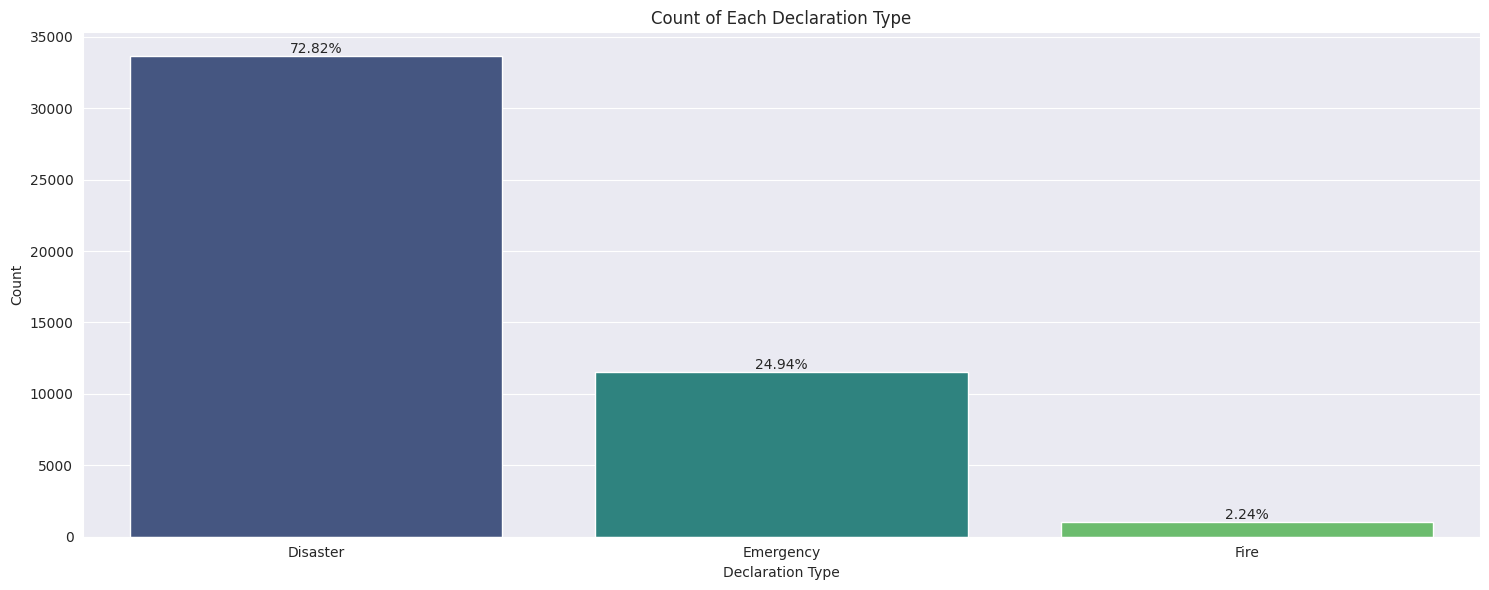

In [5]:
# Get the value counts of 'Declaration Type'
declaration_type_counts = df['Declaration Type'].value_counts()

# Calculate the percentage of each declaration type
total_count = declaration_type_counts.sum()
percentages = (declaration_type_counts / total_count) * 100

# Plot the value counts using seaborn barplot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=declaration_type_counts.index, y=declaration_type_counts.values, hue=declaration_type_counts.index, palette='viridis')

# Add labels and title
plt.xlabel('Declaration Type')
plt.ylabel('Count')
plt.title('Count of Each Declaration Type')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout();


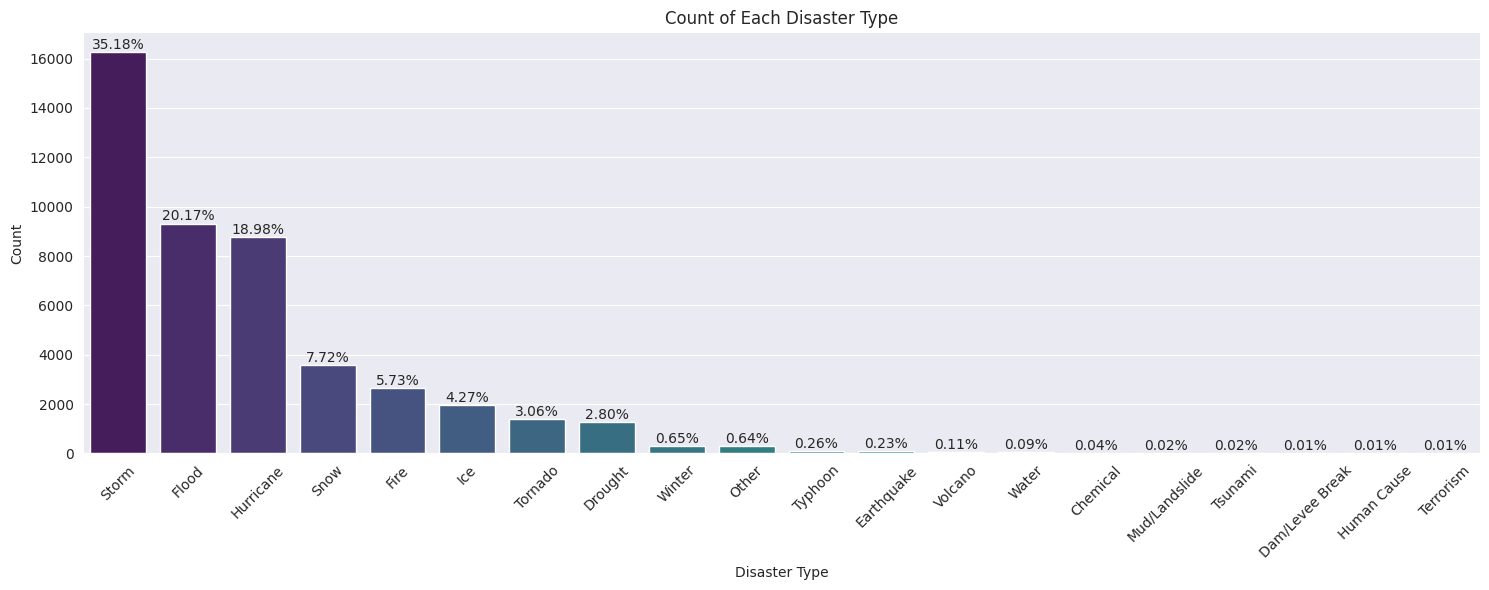

In [6]:
# Get the value counts of 'Disaster Type'
disaster_type_counts = df['Disaster Type'].value_counts()

# Calculate the percentage of each disaster type
total_count = disaster_type_counts.sum()
percentages = (disaster_type_counts / total_count) * 100

# Plot the value counts using seaborn barplot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=disaster_type_counts.index, y=disaster_type_counts.values, hue=disaster_type_counts.index, palette='viridis')

# Add labels and title
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Count of Each Disaster Type')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45)  
plt.tight_layout();

In [7]:
# Convert dates to datetime and set index
df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
df.set_index('Declaration Date', inplace=True)

# Aggregate disaster counts by year
count_of_disasters_df = df.resample('ME').size().reset_index(name='count_of_disaster')

In [8]:
count_of_disasters_df.head()

,Declaration Date,count_of_disaster
0,1953-05-31,3
1,1953-06-30,6
2,1953-07-31,1
3,1953-08-31,0
4,1953-09-30,0


In [9]:
count_of_disasters_df1 = count_of_disasters_df.copy()
# Set 'Declaration Date' as index for the resampled data
count_of_disasters_df1.set_index('Declaration Date', inplace=True)

# Ensure the time series data is from the 'count' column
time_series_data = count_of_disasters_df1['count_of_disaster']

# Ensure the frequency is set correctly (monthly data in this case)
time_series_data = time_series_data.asfreq('ME')

In [10]:
time_series_data.head()

Declaration Date
1953-05-31    3
1953-06-30    6
1953-07-31    1
1953-08-31    0
1953-09-30    0
Freq: ME, Name: count_of_disaster, dtype: int64

In [11]:
are_equal = time_series_data.equals(count_of_disasters_df)
print(are_equal)

False


In [12]:
# Convert the Series to DataFrame
time_series_data_df = time_series_data.to_frame()

# Now compare both DataFrames
are_equal = count_of_disasters_df.equals(time_series_data_df)
print(are_equal)

False


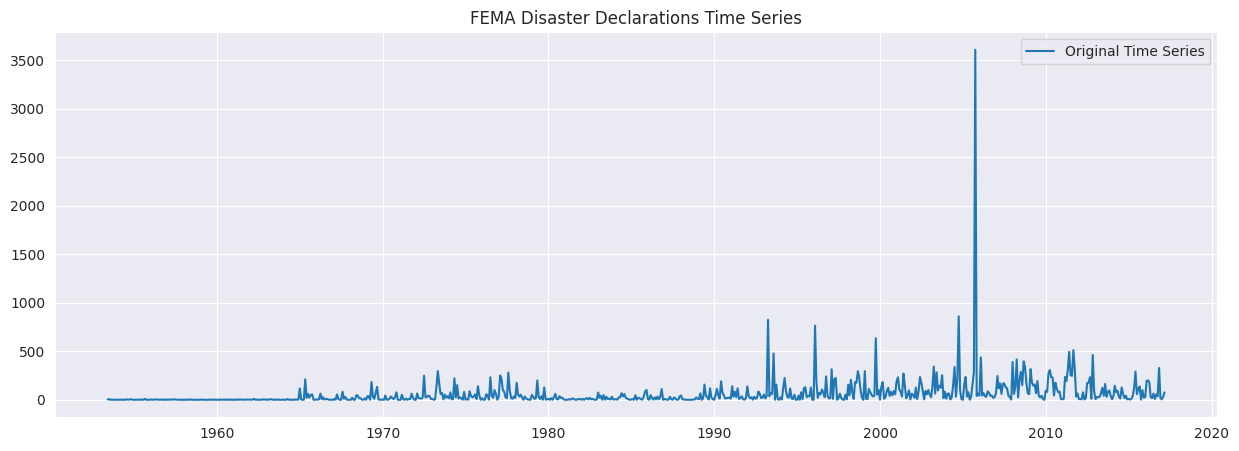

In [13]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(time_series_data, label='Original Time Series')
plt.title('FEMA Disaster Declarations Time Series')
plt.legend()
plt.show()

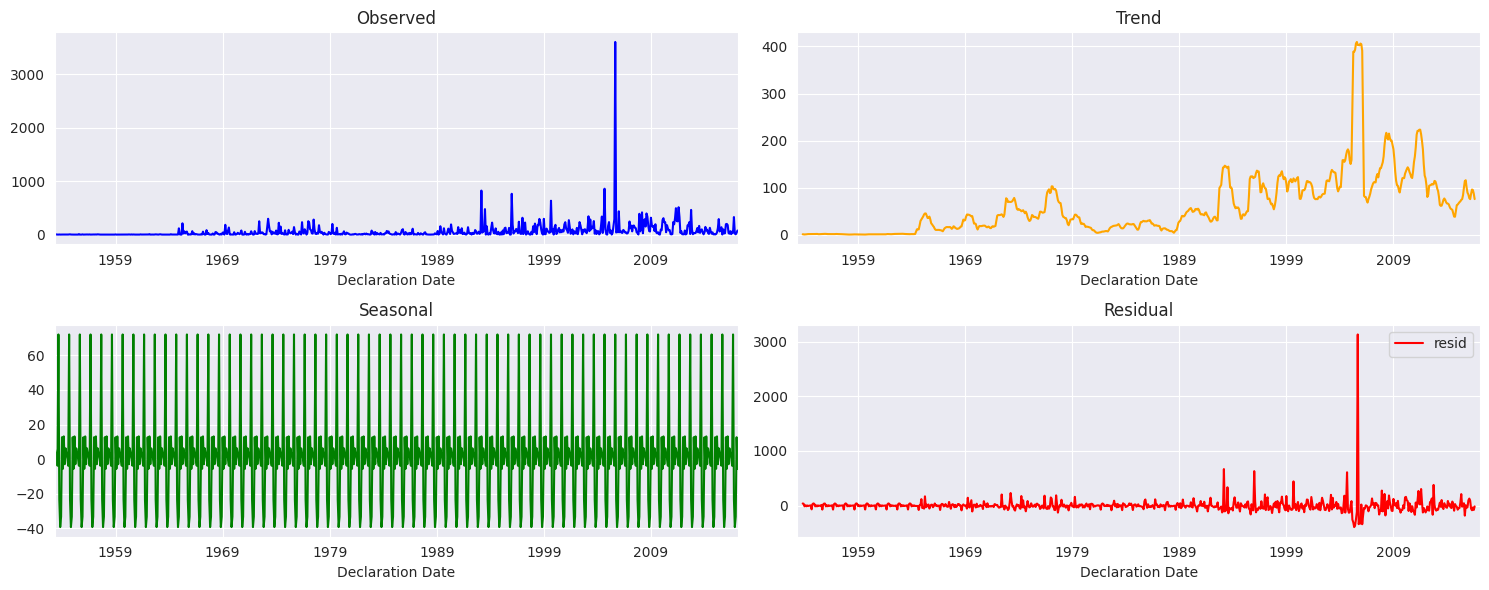

In [14]:
# Decompose the time series
decompose_result = seasonal_decompose(time_series_data, model='additive')

fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot each component in a separate subplot
decompose_result.observed.plot(ax=axes[0, 0], title='Observed', color='blue')
decompose_result.trend.plot(ax=axes[0, 1], title='Trend', color='orange')
decompose_result.seasonal.plot(ax=axes[1, 0], title='Seasonal', color='green')
decompose_result.resid.plot(ax=axes[1, 1], title='Residual', color='red')

plt.legend()
plt.tight_layout();

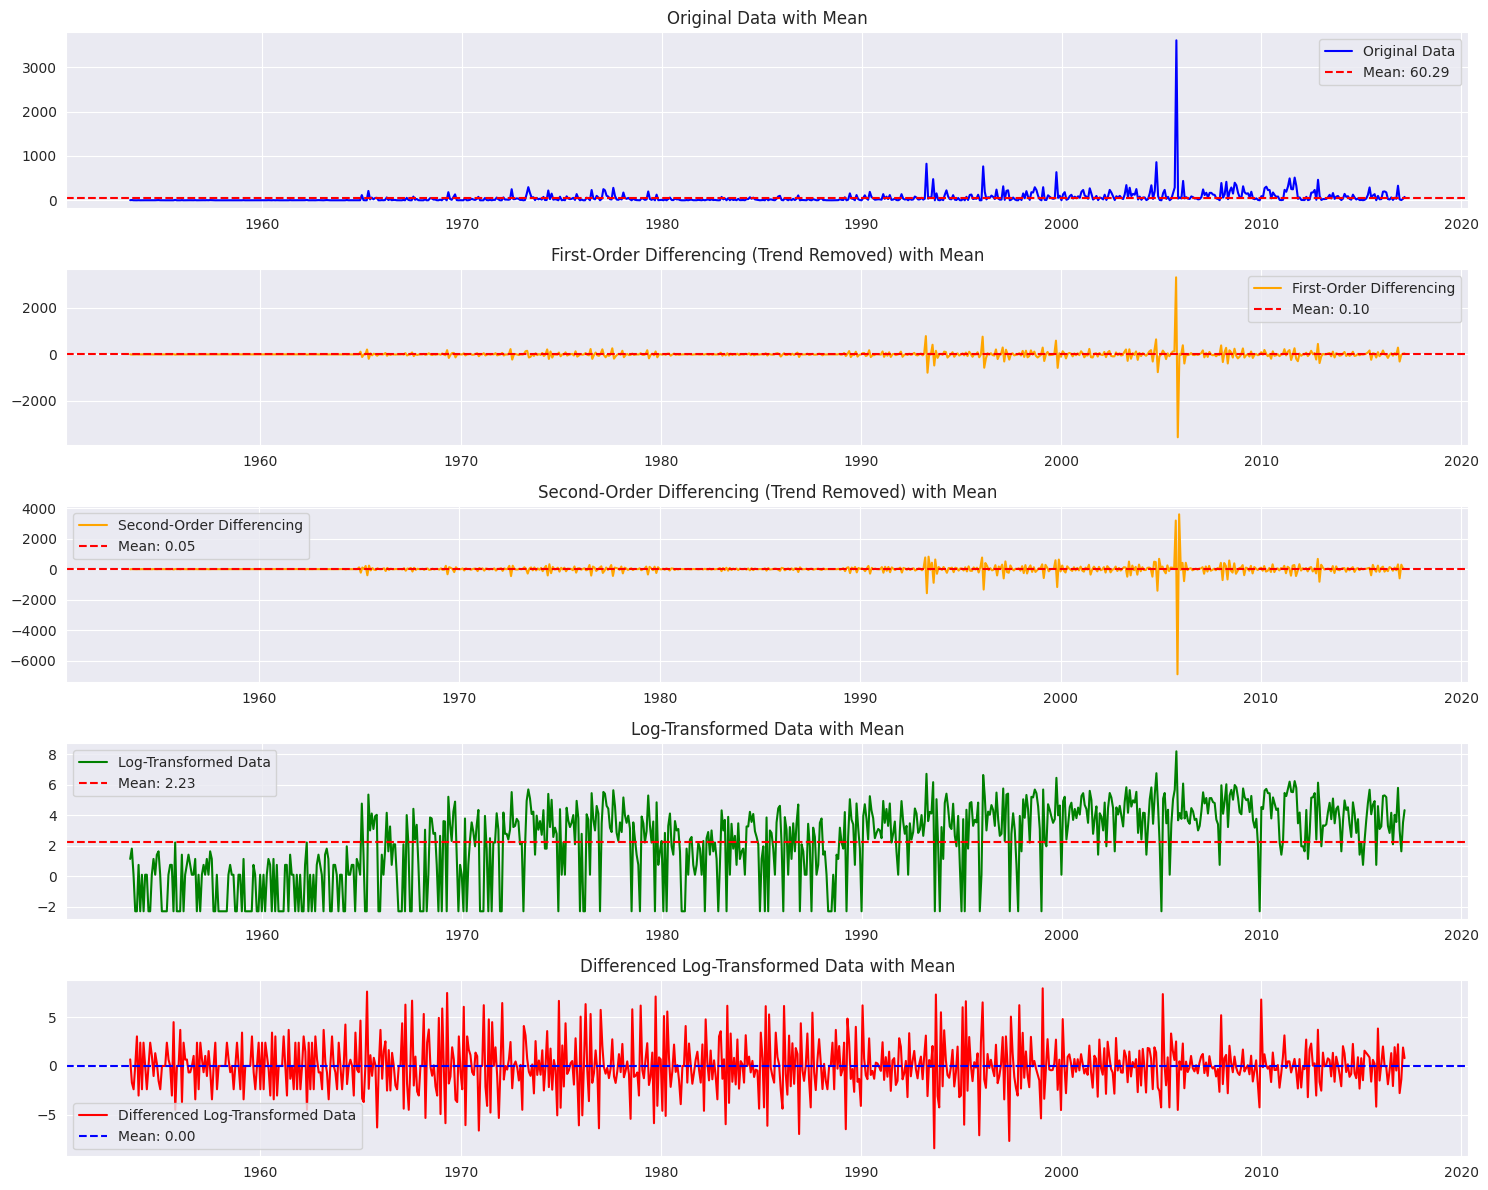

In [15]:
first_differenced = time_series_data.diff().dropna() # First Differenced Data

second_differenced = first_differenced.diff().dropna() # Second Differenced Data

log_transformed = np.log(time_series_data + .1).replace(-np.inf, np.nan).dropna() # Log-Transformed Data

log_diff = log_transformed.diff().dropna() # Differenced Log-Transformed Data

# Calculate means for each transformation
original_mean = time_series_data.mean()
first_differenced_mean = first_differenced.mean()
second_differenced_mean = second_differenced.mean()
log_transformed_mean = log_transformed.mean()
log_diff_mean = log_diff.mean()

# Plot the Original Data with mean
plt.figure(figsize=(15, 12))
plt.subplot(5, 1, 1)
plt.plot(time_series_data, label="Original Data", color='blue')
plt.axhline(original_mean, color='red', linestyle='--', label=f"Mean: {original_mean:.2f}")
plt.title("Original Data with Mean")
plt.legend()

# Plot the First Differenced Data with mean
plt.subplot(5, 1, 2)
plt.plot(first_differenced, label="First-Order Differencing", color='orange')
plt.axhline(first_differenced_mean, color='red', linestyle='--', label=f"Mean: {first_differenced_mean:.2f}")
plt.title("First-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Second Differenced Data with mean
plt.subplot(5, 1, 3)
plt.plot(second_differenced, label="Second-Order Differencing", color='orange')
plt.axhline(second_differenced_mean, color='red', linestyle='--', label=f"Mean: {second_differenced_mean:.2f}")
plt.title("Second-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Log-Transformed Data with mean
plt.subplot(5, 1, 4)
plt.plot(log_transformed, label="Log-Transformed Data", color='green')
plt.axhline(log_transformed_mean, color='red', linestyle='--', label=f"Mean: {log_transformed_mean:.2f}")
plt.title("Log-Transformed Data with Mean")
plt.legend()  

# Plot the Differenced Log-Transformed Data with mean
plt.subplot(5, 1, 5)
plt.plot(log_diff, label="Differenced Log-Transformed Data", color='red')
plt.axhline(log_diff_mean, color='blue', linestyle='--', label=f"Mean: {log_diff_mean:.2f}")
plt.title("Differenced Log-Transformed Data with Mean")
plt.legend()

plt.tight_layout();

### Stationary Check

#### Which Test Should We Choose: ADF or KPSS?

Choosing between the ADF and KPSS tests can sometimes be confusing. A practical approach is to apply both tests and cross-check their conclusions to confirm if the series is truly stationary. The following outcomes can help interpret the results:
- **Case 1:** Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2:** Both tests conclude that the series is stationary - The series is stationary
- **Case 3:** KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [16]:
# ADF Test
def adf_test(timeseries, regression='c'):
    """
    Perform Augmented Dickey-Fuller (ADF) Test.

    Parameters:
    timeseries: The time series data.
    regression: {'c', 'ct', 'ctt', 'n}.
                'c' : constant only (default). 
                'ct' : constant and trend.
                'ctt' : constant, and linear and quadratic trend.
                'nc' : no constant, no trend.
    
    Returns:
    Results of the ADF test in a Pandas Series.
    """
    print("ADF Test:\n")
    print("Null Hypothesis (H0): The series has a unit root or is non-stationary.")
    print("Alternate Hypothesis (H1): The series has no unit root or is stationary.\n")
    print("Results of Dickey-Fuller Test:\n")
    adf_result = adfuller(timeseries, regression=regression, autolag='AIC')
    adf_output = pd.Series(
        adf_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "Observations Used"]
    )
    for key, value in adf_result[4].items():
        adf_output[f"Critical Value ({key})"] = value
    print(adf_output,'\n')
    
    if adf_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is stationary.\n")
    else:
        print("Fail to Reject H0: The series is non-stationary.\n")
        

# KPSS Test
def kpss_test(timeseries, regression='c'):
    """
    Perform KPSS Test.

    Parameters:
    timeseries: The time series data.
    regression: 'c' for constant, 'ct' for constant and trend.
    
    Returns:
    Results of the KPSS test in a Pandas Series.
    """
    print("KPSS Test:\n")
    print("Null Hypothesis (H0): The series is trend stationary or has no unit root.")
    print("Alternate Hypothesis (H1): The series has a unit root (is non-stationary).\n")
    print("Results of KPSS Test:\n")
    kpss_result = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(
        kpss_result[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_result[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output,'\n')
    
    if kpss_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is non-stationary.\n")
    else:
        print("Fail to Reject H0: The series is stationary.\n")


In [17]:
# Check stationarity with ADF Test
adf_test(time_series_data, regression='ct') 

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -6.544486e+00
p-value                 1.473011e-07
Lags Used               1.100000e+01
Observations Used       7.540000e+02
Critical Value (1%)    -3.970827e+00
Critical Value (5%)    -3.416329e+00
Critical Value (10%)   -3.130486e+00
dtype: float64 

Reject H0: The series is stationary.



In [18]:
# Check stationarity with KPSS Test
kpss_test(time_series_data, regression='ct')

KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic           0.171615
p-value                  0.028654
Lags Used                8.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64 

Reject H0: The series is non-stationary.



Check Stationarity with ADF and KPSS Test:
- **Based on the ADF Test, the series is stationary** because the p-value is less than the significant level 0.05, leading to the rejection of the null hypothesis.
- **Based on the KPSS Test, the series is non-stationary** because the p-value is less than the significant level 0.05, leading to the rejection of the null hypothesis.
- **Conclusion: The series is difference stationary.** Differencing is to be used to make series stationary. 

In [19]:
# Apply differencing to make the series stationary
time_series_data_diff = time_series_data.diff().dropna()

In [20]:
# Recheck for strict stationarity.
adf_test(time_series_data_diff, regression='ct')
print() 
kpss_test(time_series_data_diff, regression='ct')

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.323496e+01
p-value                 6.963061e-21
Lags Used               1.400000e+01
Observations Used       7.500000e+02
Critical Value (1%)    -3.970892e+00
Critical Value (5%)    -3.416360e+00
Critical Value (10%)   -3.130504e+00
dtype: float64 

Reject H0: The series is stationary.


KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.028874
p-value                   0.100000
Lags Used                39.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64 

Fail to Reject H0: The series is stationary.



/tmp/ipykernel_144414/1974365690.py:51: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression=regression, nlags="auto")


#### Determining $p$ and $q$ from PACF and ACF:

- `Cuts off`: The value drops abruptly to zero.
- `Tails off`: The value gradually decays towards zero, usually in an exponential way.

- Select $p$ based on significant spikes from the PACF plot. 
    - One clue is that the ACF plot decays more slowly.
- Select $q$ from ACF if this plot has a sharp cut-off after lag $q$. 
    - One clue is that the PACF plot decays more slowly.

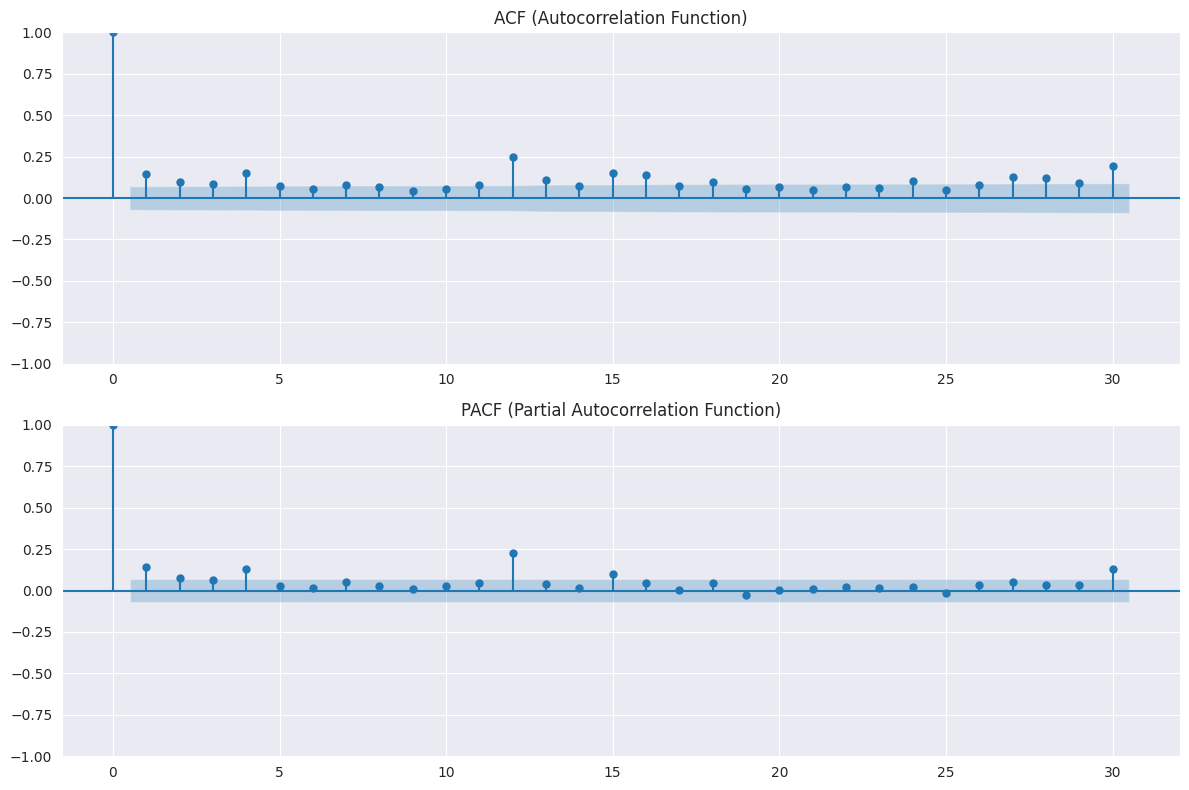

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_acf(time_series_data, lags=30, alpha=0.05, ax=ax1)  
ax1.set_title('ACF (Autocorrelation Function)')

# Plot PACF (Partial Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_pacf(time_series_data, lags=30, alpha=0.05, ax=ax2)  
ax2.set_title('PACF (Partial Autocorrelation Function)')

plt.tight_layout();

- From the ACF plot, the twelfth lag stands out the most, indicating a clear **seasonal pattern** that repeats **every 12 months**, as the data is monthly.
- Once again, the **twelfth** lag is the most prominent in the PACF plot.

# LSTM

The Long Short Term Memory (LSTM) is the advanced type of RNN, which was designed to prevent both decaying and exploding gradient problems. Just like RNN, LSTM has repeating modules, but the structure is different. Instead of having a single layer of tanh, LSTM has four interacting layers that communicate with each other. This four-layered structure helps LSTM retain long-term memory and can be used in several sequential problems including machine translation, speech synthesis, speech recognition, and handwriting recognition.

In [22]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler, RobustScaler


set_seed(29)
np.random.seed(29)

2025-01-10 01:48:02.708107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
count_of_disasters_df.head()

,Declaration Date,count_of_disaster
0,1953-05-31,3
1,1953-06-30,6
2,1953-07-31,1
3,1953-08-31,0
4,1953-09-30,0


In [24]:
count_of_disasters_df.isnull().sum()

Declaration Date     0
count_of_disaster    0
dtype: int64

## Data Preparation

In [25]:
def normalize_data(train_data, val_data, test_data):
    # Initialize a MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler on the training data and transform the validation and test set
    train_scaled = scaler.fit_transform(val_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Convert back to DataFrame and ensure column names are retained
    train_df_scaled = pd.DataFrame(train_scaled, columns=val_data.columns, index=val_data.index)
    val_df_scaled = pd.DataFrame(val_scaled, columns=val_data.columns, index=val_data.index)
    test_df_scaled = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)

    return train_df_scaled, val_df_scaled, test_df_scaled, scaler



class WindowGenerator:
    def __init__(self, input_width, label_width, shift, 
                 train_df, val_df, test_df, batch_size, label_columns=None):
        # Store the input parameters
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        else:
            self.label_columns_indices = None

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size)

        ds = ds.map(self.split_window)
        
        X, y = [], []
        for window in ds:
            inputs, labels = window  
        
            X.append(inputs)
            y.append(labels)

        X = np.concatenate(X, axis=0)  # Shape: [num_samples, input_width, num_features]
        y = np.concatenate(y, axis=0)  # Shape: [num_samples, label_width, num_features]
        
        print(f"Shape of X before reshaping: {X.shape}")
        print(f"Shape of y before reshaping: {y.shape}")
        
        X = np.reshape(X, (-1, self.input_width, 1))  
        y = np.reshape(y, (-1, self.label_width, 1))  


        return X, y
    
    @staticmethod
    def normalize_data(X_train, X_val, X_test):
        n_train, input_width, n_features = X_train.shape
        n_val, input_width, n_features = X_val.shape
        n_test, input_width, n_features = X_test.shape

        X_train_flattened = X_train.reshape(-1, n_features)
        X_val_flattened = X_val.reshape(-1, n_features)
        X_test_flattened = X_test.reshape(-1, n_features)

        # scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = RobustScaler()

        X_train_scaled_flattened = scaler.fit_transform(X_train_flattened)
        X_val_scaled_flattened = scaler.transform(X_val_flattened)
        X_test_scaled_flattened = scaler.transform(X_test_flattened)

        X_train_scaled = X_train_scaled_flattened.reshape(n_train, input_width, n_features)
        X_val_scaled = X_val_scaled_flattened.reshape(n_val, input_width, n_features)
        X_test_scaled = X_test_scaled_flattened.reshape(n_test, input_width, n_features)

        return X_train_scaled, X_val_scaled, X_test_scaled, scaler


    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result
    
    
def get_true_labels(dataset):
    all_labels = []
    for _, labels in dataset:  
        all_labels.append(labels.numpy())  
    return np.concatenate(all_labels, axis=0)  

In [26]:
def plot_loss_curves(history):
    # Extract loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the loss curves
    plt.figure(figsize=(15, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();  
    

def plot_predictions(test, predicted):
    plt.figure(figsize=(15, 5))
    plt.plot(test, label="Actual")
    plt.plot(predicted, label="Predicted")
    plt.title("Disaster Prediction")
    plt.xlabel("Time")
    plt.ylabel("Disaster Count")
    plt.legend()
    plt.show()


In [ ]:
count_of_disasters_df_cp = count_of_disasters_df.copy()

count_of_disasters_df_drop = count_of_disasters_df_cp.drop(columns=['Declaration Date'])

# Split data into train, validation, and test sets
n = len(count_of_disasters_df_drop)
train_df = count_of_disasters_df_drop[0:int(n*0.7)]
val_df = count_of_disasters_df_drop[int(n*0.7):int(n*0.9)]
test_df = count_of_disasters_df_drop[int(n*0.9):]


# # Normalize the data
# train_df_scaled, val_df_scaled, test_df_scaled, scaler = normalize_data(train_df, val_df, test_df)


# Initialize the WindowGenerator
window_generator = WindowGenerator(input_width=12, # 12 months of input (1 year)
                                   label_width=12,  # 12 month of output
                                   shift=1,        # Predict the next month
                                   train_df=train_df, 
                                   val_df=val_df, 
                                   test_df=test_df,
                                   batch_size=64)


# # Call train_ds, val_ds, and test_ds, they will already be normalized
# train_ds = window_generator.train
# val_ds = window_generator.val
# test_ds = window_generator.test

# Get the training data as X (inputs) and y (labels)
X_train, y_train = window_generator.make_dataset(window_generator.train_df)

# Get the validation data
X_val, y_val = window_generator.make_dataset(window_generator.val_df)

# Get the test data
X_test, y_test = window_generator.make_dataset(window_generator.test_df)

# Normalize the data
X_train_scaled, X_val_scaled, X_test_scaled, scaler = window_generator.normalize_data(X_train, X_val, X_test)


Shape of X before reshaping: (524, 12, 1)
Shape of y before reshaping: (524, 12, 1)
Shape of X before reshaping: (141, 12, 1)
Shape of y before reshaping: (141, 12, 1)
Shape of X before reshaping: (65, 12, 1)
Shape of y before reshaping: (65, 12, 1)


2025-01-10 01:48:04.660778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-10 01:48:04.726540: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(524, 12, 1)
(141, 12, 1)
(65, 12, 1)


In [29]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(524, 12, 1)
(141, 12, 1)
(65, 12, 1)


In [30]:
print(np.isnan(X_train_scaled).any())
print(np.isnan(X_val_scaled).any())
print(np.isnan(X_test_scaled).any())
print(np.isnan(y_train).any())
print(np.isnan(y_val).any())
print(np.isnan(y_test).any())

False
False
False
False
False
False


In [31]:
print("Minimum value of y_train : ", np.min(y_train))
print("Maximum value of y_train : ", np.max(y_train))  
print("Average absolute value of y_train : ", np.mean(np.abs(y_train)))  
print("Count values close to zero : ", np.sum(np.abs(y_train) < 1e-5))
print()
print("Minimum value of y_val : ", np.min(y_val))
print("Maximum value of y_val : ", np.max(y_val))  
print("Average absolute value of y_val : ", np.mean(np.abs(y_val)))  
print("Count values close to zero : ", np.sum(np.abs(y_val) < 1e-5))
print()
print("Minimum value of y_test : ", np.min(y_test))
print("Maximum value of y_test : ", np.max(y_test))  
print("Average absolute value of y_test : ", np.mean(np.abs(y_test)))  
print("Count values close to zero : ", np.sum(np.abs(y_test) < 1e-5))

Minimum value of y_train :  0.0
Maximum value of y_train :  824.0
Average absolute value of y_train :  31.161577
Count values close to zero :  1411

Minimum value of y_val :  0.0
Maximum value of y_val :  3607.0
Average absolute value of y_val :  144.51064
Count values close to zero :  34

Minimum value of y_test :  2.0
Maximum value of y_test :  512.0
Average absolute value of y_test :  95.78974
Count values close to zero :  0


In [32]:
y_train.shape

(524, 12, 1)

In [33]:
# Apply Log Transform to avoid many zeros
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

There's one additional rule of thumb that helps for supervised learning problems. 
You can usually prevent over-fitting if you keep your number of neurons below:

$$ N_h = \frac{N_s}{\alpha \cdot (N_i + N_o)} $$

Where:
- $N_i$ = number of input neurons.
- $N_o$ = number of output neurons.
- $N_s$ = number of samples in the training data set.
- $\alpha$ = an arbitrary scaling factor, usually between 2 and 10.


In [34]:
def calculate_hidden_units_from_data(train_data, alpha=5):
    # Ensure alpha is within the accepted range
    if alpha < 2 or alpha > 10:
        raise ValueError("Alpha must be between 2 and 10.")
    
    # Get the number of samples (N_s) and the number of input features (N_i)
    if len(train_data.shape) == 2:
        n_samples = train_data.shape[0]
        n_inputs = train_data.shape[1]
    elif len(train_data.shape) == 3:
        n_samples = train_data.shape[0]
        n_inputs = train_data.shape[2]
    else:
        print("Check the X shape")
    
    # Number of output neurons for univariate time series (N_o)
    n_outputs = 1  # For univariate time series, we assume 1 output neuron
    
    # Calculate N_h based on the rule of thumb
    n_h = n_samples / (alpha * (n_inputs + n_outputs))
    
    return int(n_h)



# Calculate the number of hidden units: N_h 
hidden_units = calculate_hidden_units_from_data(X_train, alpha=5)
print(f"Suggested number of hidden units (N_h): {hidden_units}")


Suggested number of hidden units (N_h): 52


#### LSTM Model

In [35]:
################  Define custom metrics  ################

# Define a small epsilon value to avoid division by zero
epsilon = tf.keras.backend.epsilon()


# Define custom metrics with checks to avoid division by zero
def mape(y_true, y_pred):
    y_true = tf.where(y_true == 0, epsilon, y_true)
    return tf.reduce_mean(tf.abs((y_pred - y_true) / y_true)) * 100

def me(y_true, y_pred):
    return tf.reduce_mean(y_pred - y_true)

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_pred - y_true))

def mpe(y_true, y_pred):
    y_true = tf.where(y_true == 0, epsilon, y_true)
    return tf.reduce_mean((y_pred - y_true) / y_true) * 100

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def weighted_huber_loss(y_true, y_pred):
    # Calculate residuals
    residuals = tf.abs(y_true - y_pred)
    weights = 1 / (1 + residuals)  # Weight inversely proportional to residuals
    huber_loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    return tf.reduce_mean(weights * huber_loss)


def compile_and_fit(model, x_train, y_t, x_val, y_v, patience=5, max_epochs=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      restore_best_weights=True,
                                                      mode='min')

    # Learning rate scheduler to reduce LR on plateau
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.2, 
                                                        patience=2, 
                                                        min_lr=1e-6)
    
    # Model checkpoint to save the best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', 
                                                     monitor='val_loss', 
                                                     save_best_only=True, 
                                                     mode='min')

    # Compile the model with Adam optimizer and custom metrics
    model.compile(loss=weighted_huber_loss, #tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), #tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[mae, mape, me, mpe, rmse])
    
    
    # # Define SGD optimizer with a learning rate and momentum
    # optimizer_sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    # model.compile(loss=weighted_huber_loss, #tf.keras.losses.MeanSquaredError(),
    #               optimizer=optimizer_sgd, #tf.keras.optimizers.Adam(learning_rate=0.0001),
    #               metrics=[mae, mape, me, mpe, rmse])

    # Fit the model with additional callbacks
    history = model.fit(x_train, y_t,
                        epochs=max_epochs,
                        validation_data=(x_val, y_v),
                        callbacks=[early_stopping, lr_scheduler, checkpoint])
    return history



In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_units, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# lstm_model = tf.keras.models.Sequential([
#     # LSTM layer with L2 regularization
#     tf.keras.layers.LSTM(
#         units=hidden_units, 
#         return_sequences=True,  # Ensures LSTM returns the full sequence
#         kernel_regularizer=tf.keras.regularizers.l2(0.001)
#     ),
#     tf.keras.layers.Dropout(0.2),
#     # Fully connected Dense layer
#     tf.keras.layers.Dense(units=1)  # Produces one output per time step
# ])



MAX_EPOCHS = 1000
PATIENCE = 20


# Tran LSTM Model
history_lstm = compile_and_fit(lstm_model, 
                               X_train_scaled, y_train_log, 
                               X_val_scaled, y_val_log, 
                               patience=PATIENCE, max_epochs=MAX_EPOCHS)


val_performance = {}
performance = {}

# Evaluate LSTM Model
val_performance['LSTM'] = lstm_model.evaluate(X_val_scaled, y_val_log, verbose=1, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(X_test_scaled, y_test_log, verbose=0, return_dict=True)




Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7622 - mae: 2.0934 - mape: 28033396.0000 - me: -2.0460 - mpe: 18832150.0000 - rmse: 2.6468 - val_loss: 0.7192 - val_mae: 2.9252 - val_mape: 29215964.0000 - val_me: -2.8190 - val_mpe: 29215846.0000 - val_rmse: 3.1992 - learning_rate: 0.0010
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5556 - mae: 1.5898 - mape: 156732448.0000 - me: -1.1941 - mpe: 156732368.0000 - rmse: 2.0140 - val_loss: 0.6332 - val_mae: 1.9591 - val_mape: 52583024.0000 - val_me: -1.5570 - val_mpe: 52582956.0000 - val_rmse: 2.3857 - learning_rate: 0.0010
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4994 - mae: 1.4054 - mape: 261961920.0000 - me: -0.6105 - mpe: 261961888.0000 - rmse: 1.8023 - val_loss: 0.5946 - val_mae: 1.7884 - val_mape: 54386932.0000 - val_me: -1.3691 - val_mpe: 54386868.0000 - val_rmse: 2.2082 - learning_rate: 0.0010
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4797 - mae: 1.3530 - mape: 2799

Performance on Validation set


,loss,mae,mape,me,mpe,rmse
LSTM,0.448927,1.318297,62534932.0,-0.778756,62534900.0,1.618969


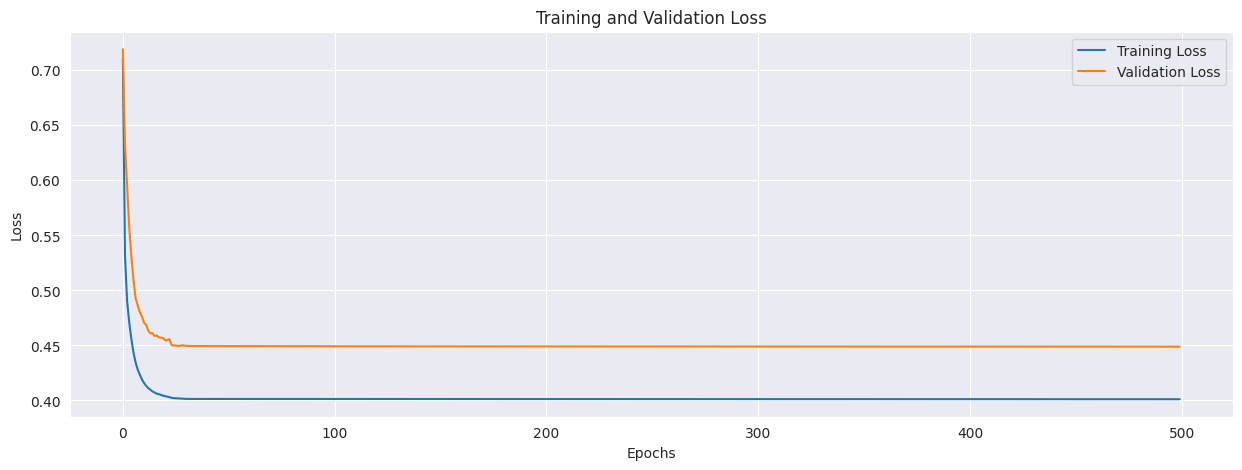

In [37]:
plot_loss_curves(history_lstm)

print("Performance on Validation set")
pd.DataFrame(val_performance).T

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


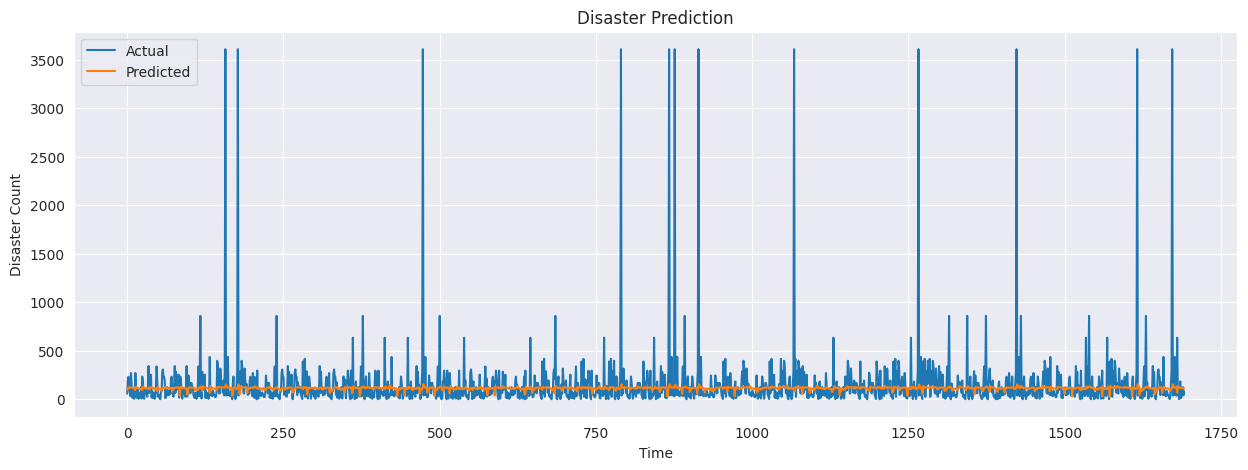

In [38]:
# Make predictions on the validation dataset
predictions_lstm = lstm_model.predict(X_val_scaled)  

# Reshape the true labels and the prediction
y_val_log_reshape = y_val_log.reshape(-1, 1) 
predictions_lstm_reshape = predictions_lstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_lstm_original = scaler.inverse_transform(predictions_lstm_reshape)
y_val_original = np.expm1(y_val_log_reshape)

# Plot the predictions against the true labels
plot_predictions(y_val_original, predictions_lstm_original)

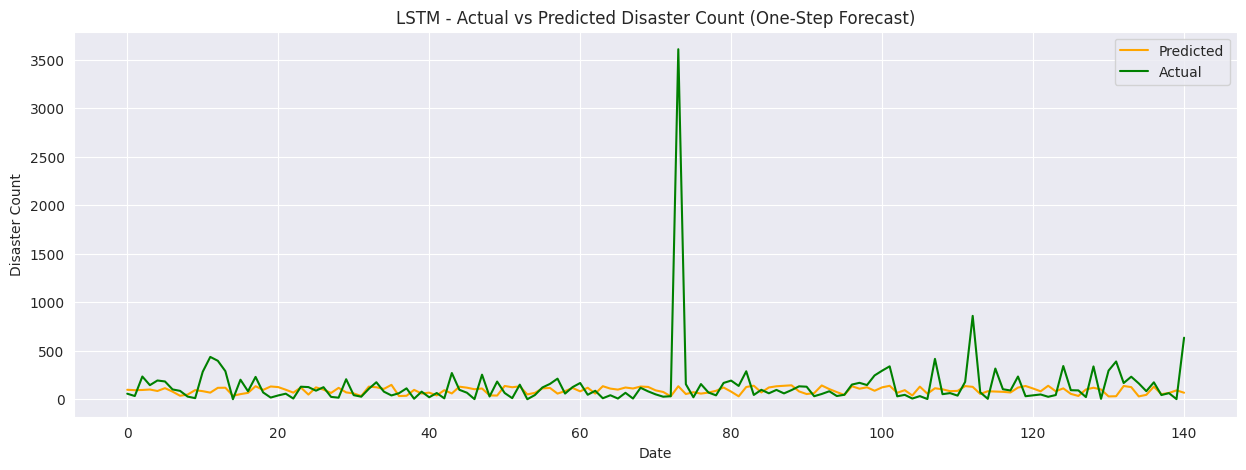

In [39]:
# Extract the first prediction from each sequence (one-step forecast)
predictions_one_step_lstm = predictions_lstm_original.reshape(-1, 12)[:, 0]  # Take the first label in each window
val_labels_one_step_lstm = y_val_original.reshape(-1, 12)[:, 0]        # Same for true labels

# Plot
plt.figure(figsize=(15, 5))
plt.plot(predictions_one_step_lstm, label='Predicted', color='orange')
plt.plot(val_labels_one_step_lstm, label='Actual', color='green')
plt.title("LSTM - Actual vs Predicted Disaster Count (One-Step Forecast)")
plt.xlabel("Date")
plt.ylabel("Disaster Count")
plt.legend()
plt.xticks(rotation=0)  
plt.grid(True);


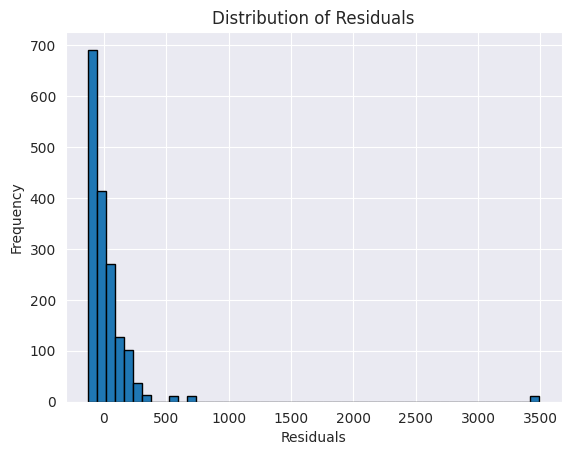

In [40]:
# Analyze residual
residuals_lstm = y_val_original - predictions_lstm_original

plt.hist(residuals_lstm, bins=50, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals');


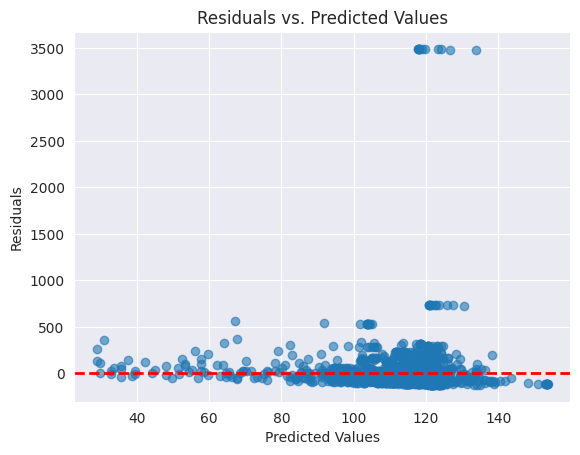

In [41]:
plt.scatter(predictions_lstm_original, residuals_lstm, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values');

In [42]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Add constant to features  
X_val_with_const = sm.add_constant(predictions_lstm_original)

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals_lstm, X_val_with_const)
bp_test_results = dict(zip(['Lagrange Multiplier Statistic', 'p-value', 'F-value', 'F p-value'], bp_test))

bp_test_results # A low p-value (< 0.05) indicates heteroscedasticity else homoscedasticity.

{'Lagrange Multiplier Statistic': 3.467529948686565,
 'p-value': 0.06258469972174607,
 'F-value': 3.4705436331362467,
 'F p-value': 0.06264415025659474}

In [43]:
from statsmodels.stats.diagnostic import het_white

# Perform White's test
white_test = het_white(residuals_lstm, X_val_with_const)
white_test_results = dict(zip(['Lagrange Multiplier Statistic', 'p-value', 'F-value', 'F p-value'], white_test))

white_test_results # A low p-value (< 0.05) indicates heteroscedasticity else homoscedasticity.


{'Lagrange Multiplier Statistic': 4.483307161428312,
 'p-value': 0.10628261211565976,
 'F-value': 2.243623967628726,
 'F p-value': 0.10638944972118917}

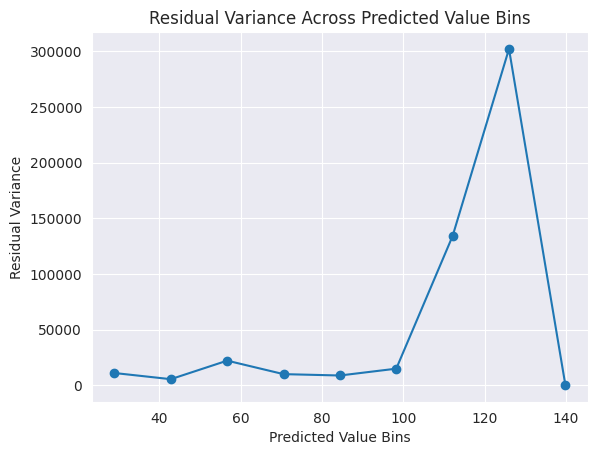

In [44]:
# Ensure predictions_lstm_original is 1D
predictions_lstm_original_1d = predictions_lstm_original.flatten()

bins = np.linspace(np.min(predictions_lstm_original_1d), np.max(predictions_lstm_original_1d), num=10)

bin_indices = np.digitize(predictions_lstm_original_1d, bins)

residual_variances = [
    np.var(residuals_lstm[bin_indices == i]) for i in range(1, len(bins))
]

plt.plot(bins[:-1], residual_variances, marker='o')
plt.xlabel('Predicted Value Bins')
plt.ylabel('Residual Variance')
plt.title('Residual Variance Across Predicted Value Bins');

# Bi-LSTM

In [ ]:
# Define Bi-LSTM Model
bi_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_units, return_sequences=True)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 1000
PATIENCE = 20

# Train Bi-LSTM Model
history_bi_lstm = compile_and_fit(bi_lstm_model,
                                  X_train_scaled, y_train_log, 
                                  X_val_scaled, y_val_log, 
                                  patience=PATIENCE, max_epochs=MAX_EPOCHS)

# Evaluate Bi-LSTM Model
val_performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_val_scaled, y_val_log, verbose=1, return_dict=True)
performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_test_scaled, y_test_log, verbose=0, return_dict=True)

Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6861 - mae: 1.8921 - mape: 45423460.0000 - me: -1.7976 - mpe: 45032828.0000 - rmse: 2.3755 - val_loss: 0.5231 - val_mae: 1.6868 - val_mape: 54771688.0000 - val_me: -1.3666 - val_mpe: 54771628.0000 - val_rmse: 1.9311 - learning_rate: 0.0010
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4142 - mae: 1.2138 - mape: 243783888.0000 - me: -0.5307 - mpe: 243783840.0000 - rmse: 1.4981 - val_loss: 0.3707 - val_mae: 1.0457 - val_mape: 78486504.0000 - val_me: -0.0508 - val_mpe: 78486480.0000 - val_rmse: 1.3959 - learning_rate: 0.0010
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3781 - mae: 1.0918 - mape: 317927296.0000 - me: -0.0704 - mpe: 317927296.0000 - rmse: 1.3696 - val_loss: 0.3628 - val_mae: 1.0063 - val_mape: 78603280.0000 - val_me: 0.1139 - val_mpe: 78603264.0000 - val_rmse: 1.3695 - learning_rate: 0.0010
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3695 - mae: 1.0710 - mape: 31401

Performance on Validation set


,loss,mae,mape,me,mpe,rmse
LSTM,0.448927,1.318297,62534932.0,-0.778756,62534900.0,1.618969
Bi-LSTM,0.109051,0.303997,13506285.0,-0.110693,11865800.0,0.591105


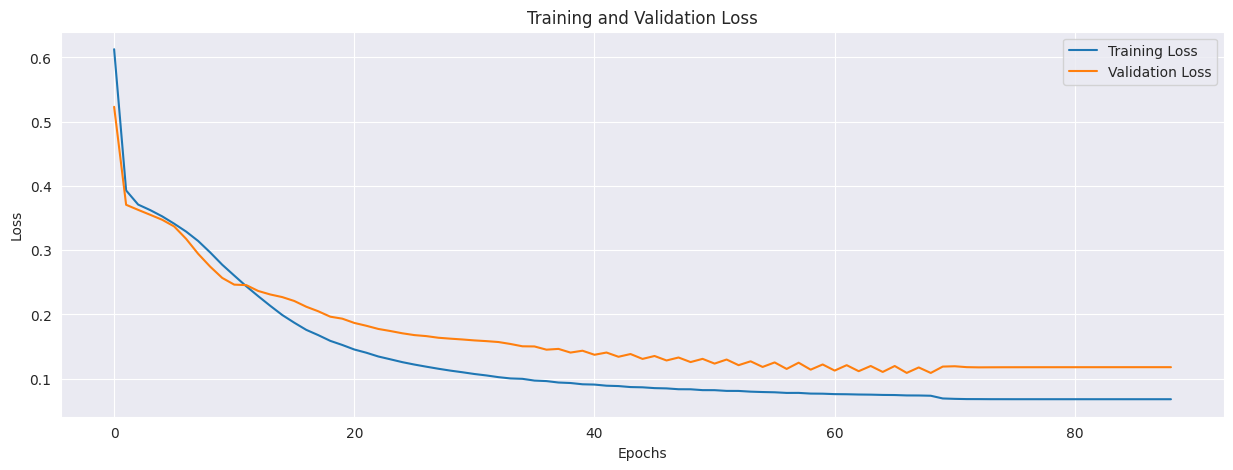

In [46]:
plot_loss_curves(history_bi_lstm)

print("Performance on Validation set")
pd.DataFrame(val_performance).T

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


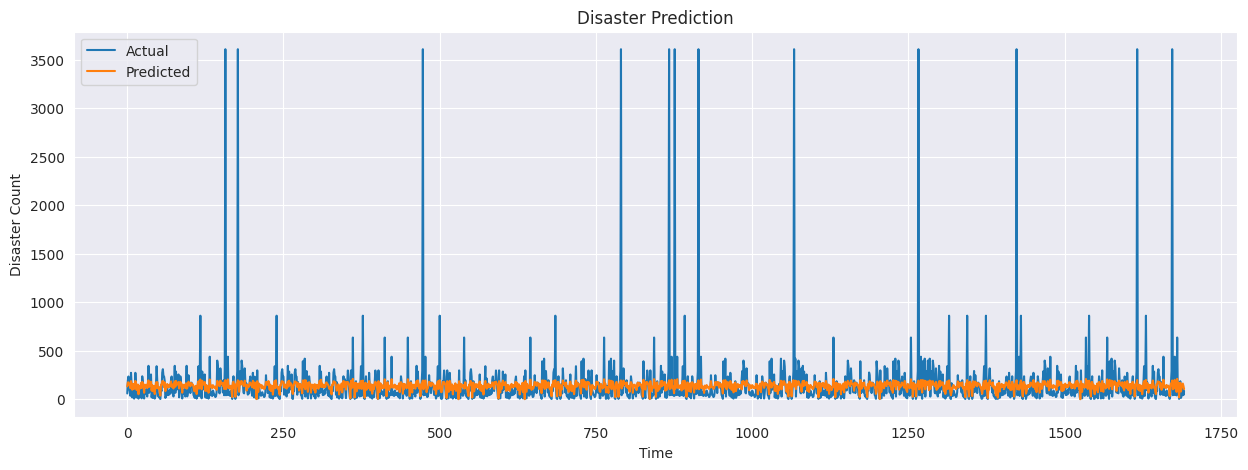

In [47]:
# Make predictions on the validation dataset
predictions_bilstm = bi_lstm_model.predict(X_val_scaled)  

# Reshape the true labels and the prediction
y_val_log_reshape = y_val_log.reshape(-1, 1) 
predictions_bilstm_reshape = predictions_bilstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_bilstm_original = scaler.inverse_transform(predictions_bilstm_reshape)
y_val_original = np.expm1(y_val_log_reshape)

# Plot the predictions against the true labels
plot_predictions(y_val_original, predictions_bilstm_original)

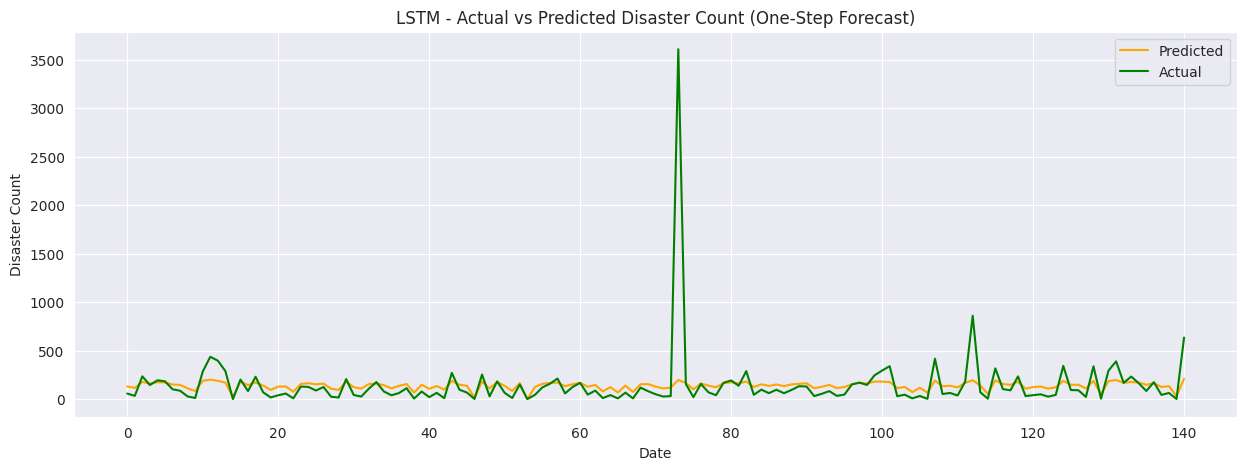

In [48]:
# Extract the first prediction from each sequence (one-step forecast)
predictions_one_step_bilstm = predictions_bilstm_original.reshape(-1, 12)[:, 0]  # Take the first label in each window
val_labels_one_step_bilstm = y_val_original.reshape(-1, 12)[:, 0]        # Same for true labels

# Plot
plt.figure(figsize=(15, 5))
plt.plot(predictions_one_step_bilstm, label='Predicted', color='orange')
plt.plot(val_labels_one_step_bilstm, label='Actual', color='green')
plt.title("LSTM - Actual vs Predicted Disaster Count (One-Step Forecast)")
plt.xlabel("Date")
plt.ylabel("Disaster Count")
plt.legend()
plt.xticks(rotation=0)  
plt.grid(True)
plt.show()


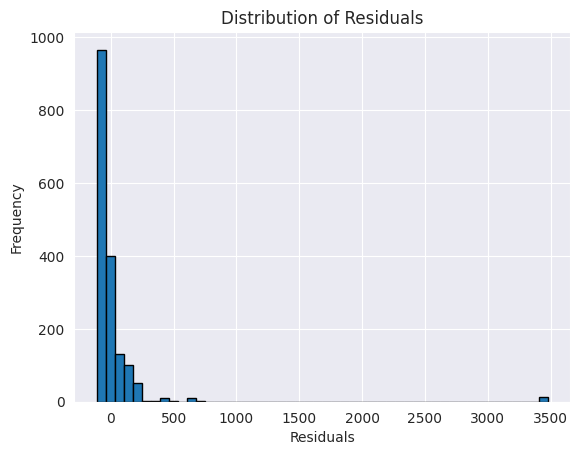

In [49]:
# Analyze residual
residuals_bilstm = y_val_original - predictions_bilstm_original

plt.hist(residuals_bilstm, bins=50, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals');

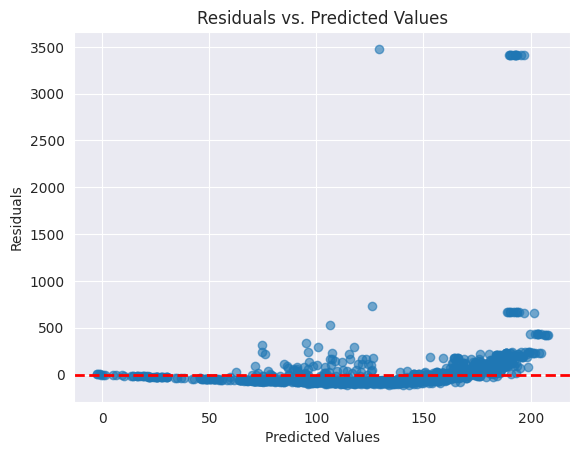

In [50]:
plt.scatter(predictions_bilstm_original, residuals_bilstm, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values');

In [51]:
# Add constant to features  
X_val_with_const_bilstm = sm.add_constant(predictions_bilstm_original)

# Perform Breusch-Pagan test
bp_test_bilstm = het_breuschpagan(residuals_bilstm, X_val_with_const_bilstm)
bp_test_results_bilstm = dict(zip(['Lagrange Multiplier Statistic', 'p-value', 'F-value', 'F p-value'], bp_test_bilstm))

bp_test_results_bilstm # A low p-value (< 0.05) indicates heteroscedasticity else homoscedasticity.


{'Lagrange Multiplier Statistic': 25.529760862469583,
 'p-value': 4.3561153651667616e-07,
 'F-value': 25.890228846752823,
 'F p-value': 4.0166310903138385e-07}

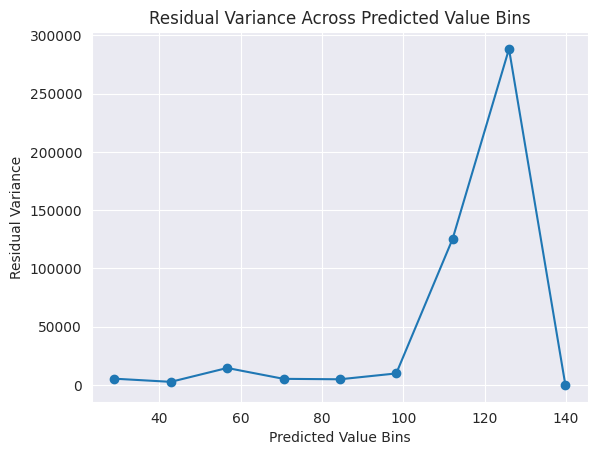

In [52]:
# Ensure predictions_lstm_original is 1D
predictions_bilstm_original_1d = predictions_lstm_original.flatten()

bins = np.linspace(np.min(predictions_bilstm_original_1d), np.max(predictions_bilstm_original_1d), num=10)

bin_indices = np.digitize(predictions_bilstm_original_1d, bins)

residual_variances_bilstm = [
    np.var(residuals_bilstm[bin_indices == i]) for i in range(1, len(bins))
]

plt.plot(bins[:-1], residual_variances_bilstm, marker='o')
plt.xlabel('Predicted Value Bins')
plt.ylabel('Residual Variance')
plt.title('Residual Variance Across Predicted Value Bins');

# GRU

The gated recurrent unit (GRU) is a variation of LSTM as both have design similarities, and in some cases, they produce similar results. GRU uses an update gate and reset gate to solve the vanishing gradient problem. These gates decide what information is important and pass it to the output. The gates can be trained to store information from long ago, without vanishing over time or removing irrelevant information.

Unlike LSTM, GRU does not have cell state $C_t$. It only has a hidden state $h_t$, and due to the simple architecture, GRU has a lower training time compared to LSTM models. The GRU architecture is easy to understand as it takes input $x_t$ and the hidden state from the previous timestamp $h_{t-1}$ and outputs the new hidden state $h_t$. 

In [ ]:
# Define GRU Model
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, gru_units]
    tf.keras.layers.GRU(hidden_units, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 1000
PATIENCE = 20

# Train GRU Model
history_gru = compile_and_fit(gru_model,
                              X_train_scaled, y_train_log, 
                              X_val_scaled, y_val_log, 
                              patience=PATIENCE, max_epochs=MAX_EPOCHS)

# Evaluate GRU Model
val_performance['GRU'] = gru_model.evaluate(X_val_scaled, y_val_log, verbose=1, return_dict=True)
performance['GRU'] = gru_model.evaluate(X_test_scaled, y_test_log, verbose=0, return_dict=True)


Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.6868 - mae: 1.9004 - mape: 48186312.0000 - me: -1.8015 - mpe: 47758344.0000 - rmse: 2.3990 - val_loss: 0.6094 - val_mae: 1.9567 - val_mape: 50465156.0000 - val_me: -1.6240 - val_mpe: 50465084.0000 - val_rmse: 2.3262 - learning_rate: 0.0010
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4928 - mae: 1.3981 - mape: 206793168.0000 - me: -0.8397 - mpe: 206793104.0000 - rmse: 1.7902 - val_loss: 0.5423 - val_mae: 1.5137 - val_mape: 70080064.0000 - val_me: -0.5519 - val_mpe: 70080016.0000 - val_rmse: 1.9737 - learning_rate: 0.0010
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4600 - mae: 1.2980 - mape: 296291296.0000 - me: -0.3714 - mpe: 296291264.0000 - rmse: 1.6598 - val_loss: 0.5151 - val_mae: 1.4365 - val_mape: 69311976.0000 - val_me: -0.4311 - val_mpe: 69311936.0000 - val_rmse: 1.8741 - learning_rate: 0.0010
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4480 - mae: 1.2682 - mape: 3136

Performance on Validation set


,loss,mae,mape,me,mpe,rmse
LSTM,0.448927,1.318297,62534932.0,-0.778756,62534900.0,1.618969
Bi-LSTM,0.109051,0.303997,13506285.0,-0.110693,11865800.0,0.591105
GRU,0.447827,1.296878,59920096.0,-0.708562,59920056.0,1.612296


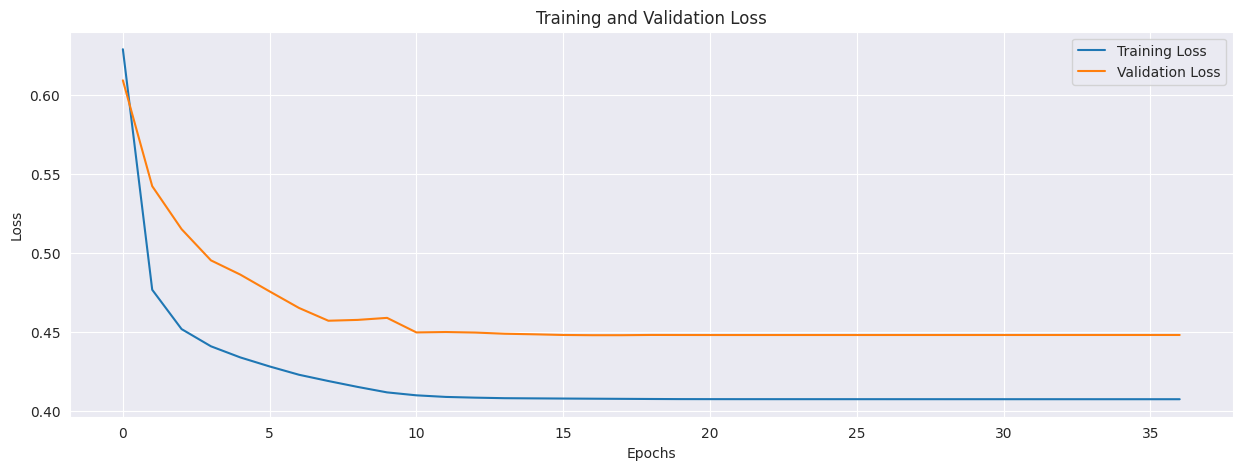

In [54]:
plot_loss_curves(history_gru)

print("Performance on Validation set")
pd.DataFrame(val_performance).T

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7140043e5c60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


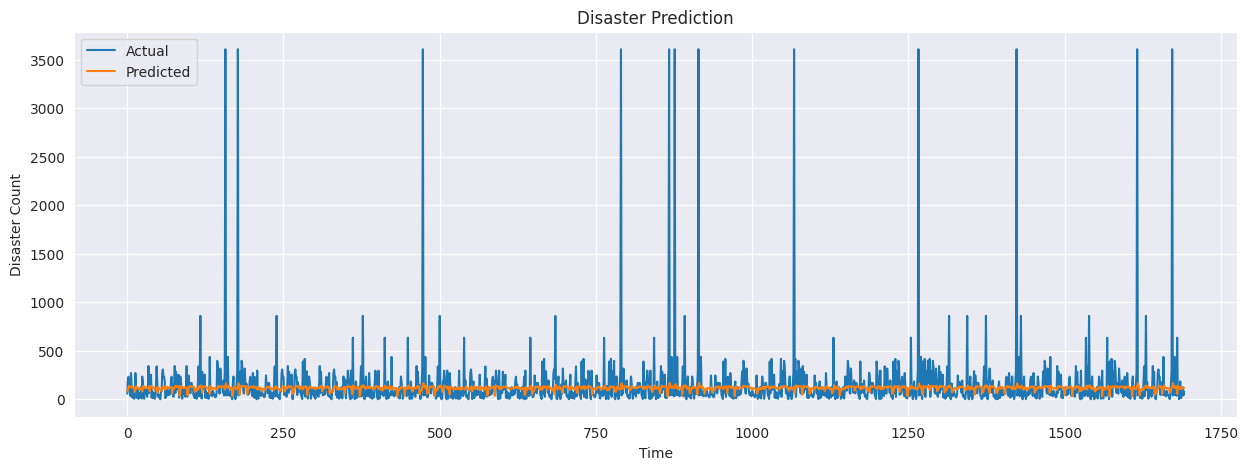

In [55]:
# Make predictions on the validation dataset
predictions_gru = gru_model.predict(X_val_scaled)  

# Reshape the true labels and the prediction
y_val_log_reshape = y_val_log.reshape(-1, 1) 
predictions_gru_reshape = predictions_gru.reshape(-1, 1)  

# Apply inverse transformation 
predictions_gru_original = scaler.inverse_transform(predictions_gru_reshape)
y_val_original = np.expm1(y_val_log_reshape)

# Plot the predictions against the true labels
plot_predictions(y_val_original, predictions_gru_original)

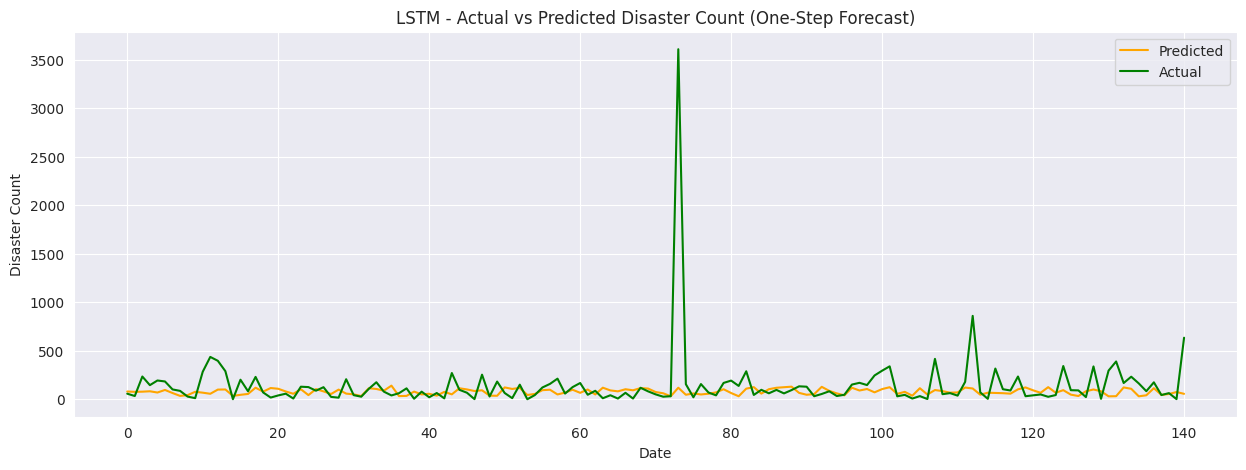

In [56]:
# Extract the first prediction from each sequence (one-step forecast)
predictions_one_step_gru = predictions_gru_original.reshape(-1, 12)[:, 0]  # Take the first label in each window
val_labels_one_step_gru = y_val_original.reshape(-1, 12)[:, 0]        # Same for true labels

# Plot
plt.figure(figsize=(15, 5))
plt.plot(predictions_one_step_gru, label='Predicted', color='orange')
plt.plot(val_labels_one_step_gru, label='Actual', color='green')
plt.title("LSTM - Actual vs Predicted Disaster Count (One-Step Forecast)")
plt.xlabel("Date")
plt.ylabel("Disaster Count")
plt.legend()
plt.xticks(rotation=0)  
plt.grid(True);


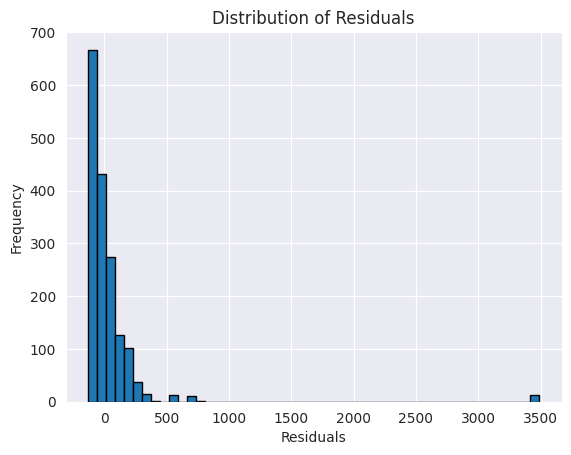

In [57]:
# Analyze residual
residuals_gru = y_val_original - predictions_gru_original

plt.hist(residuals_gru, bins=50, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals');

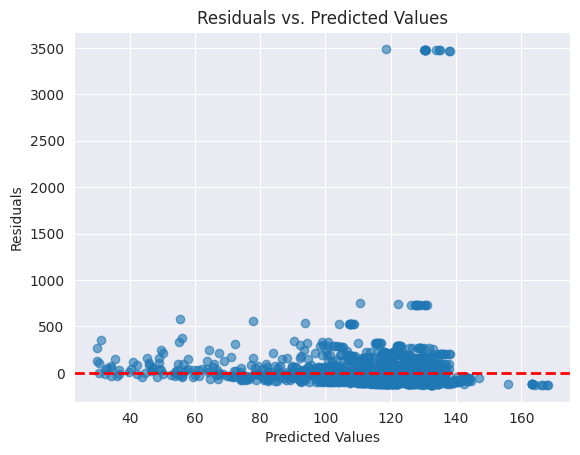

In [58]:
plt.scatter(predictions_gru_original, residuals_gru, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values');

In [59]:
# Add constant to features  
X_val_with_const_gru = sm.add_constant(predictions_gru_original)

# Perform Breusch-Pagan test
bp_test_gru = het_breuschpagan(residuals_bilstm, X_val_with_const_gru)
bp_test_results_gru = dict(zip(['Lagrange Multiplier Statistic', 'p-value', 'F-value', 'F p-value'], bp_test_gru))

bp_test_results_gru # A low p-value (< 0.05) indicates heteroscedasticity else homoscedasticity.

{'Lagrange Multiplier Statistic': 8.463214343561404,
 'p-value': 0.0036240085112139372,
 'F-value': 8.49570520969754,
 'F p-value': 0.0036067122432923236}

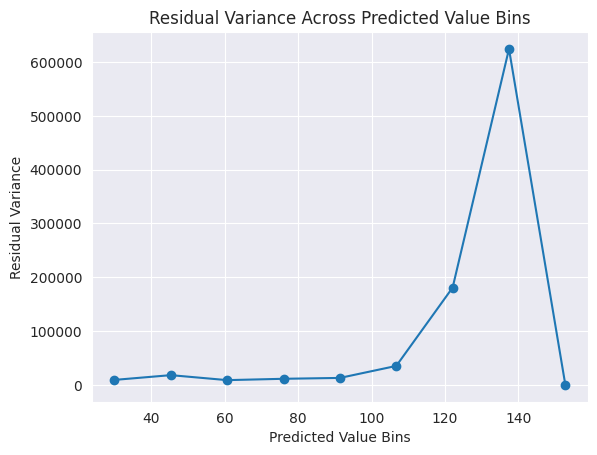

In [60]:
# Ensure predictions_lstm_original is 1D
predictions_gru_original_1d = predictions_gru_original.flatten()

bins = np.linspace(np.min(predictions_gru_original_1d), np.max(predictions_gru_original_1d), num=10)

bin_indices = np.digitize(predictions_gru_original_1d, bins)

residual_variances_gru = [
    np.var(residuals_gru[bin_indices == i]) for i in range(1, len(bins))
]

plt.plot(bins[:-1], residual_variances_gru, marker='o')
plt.xlabel('Predicted Value Bins')
plt.ylabel('Residual Variance')
plt.title('Residual Variance Across Predicted Value Bins');

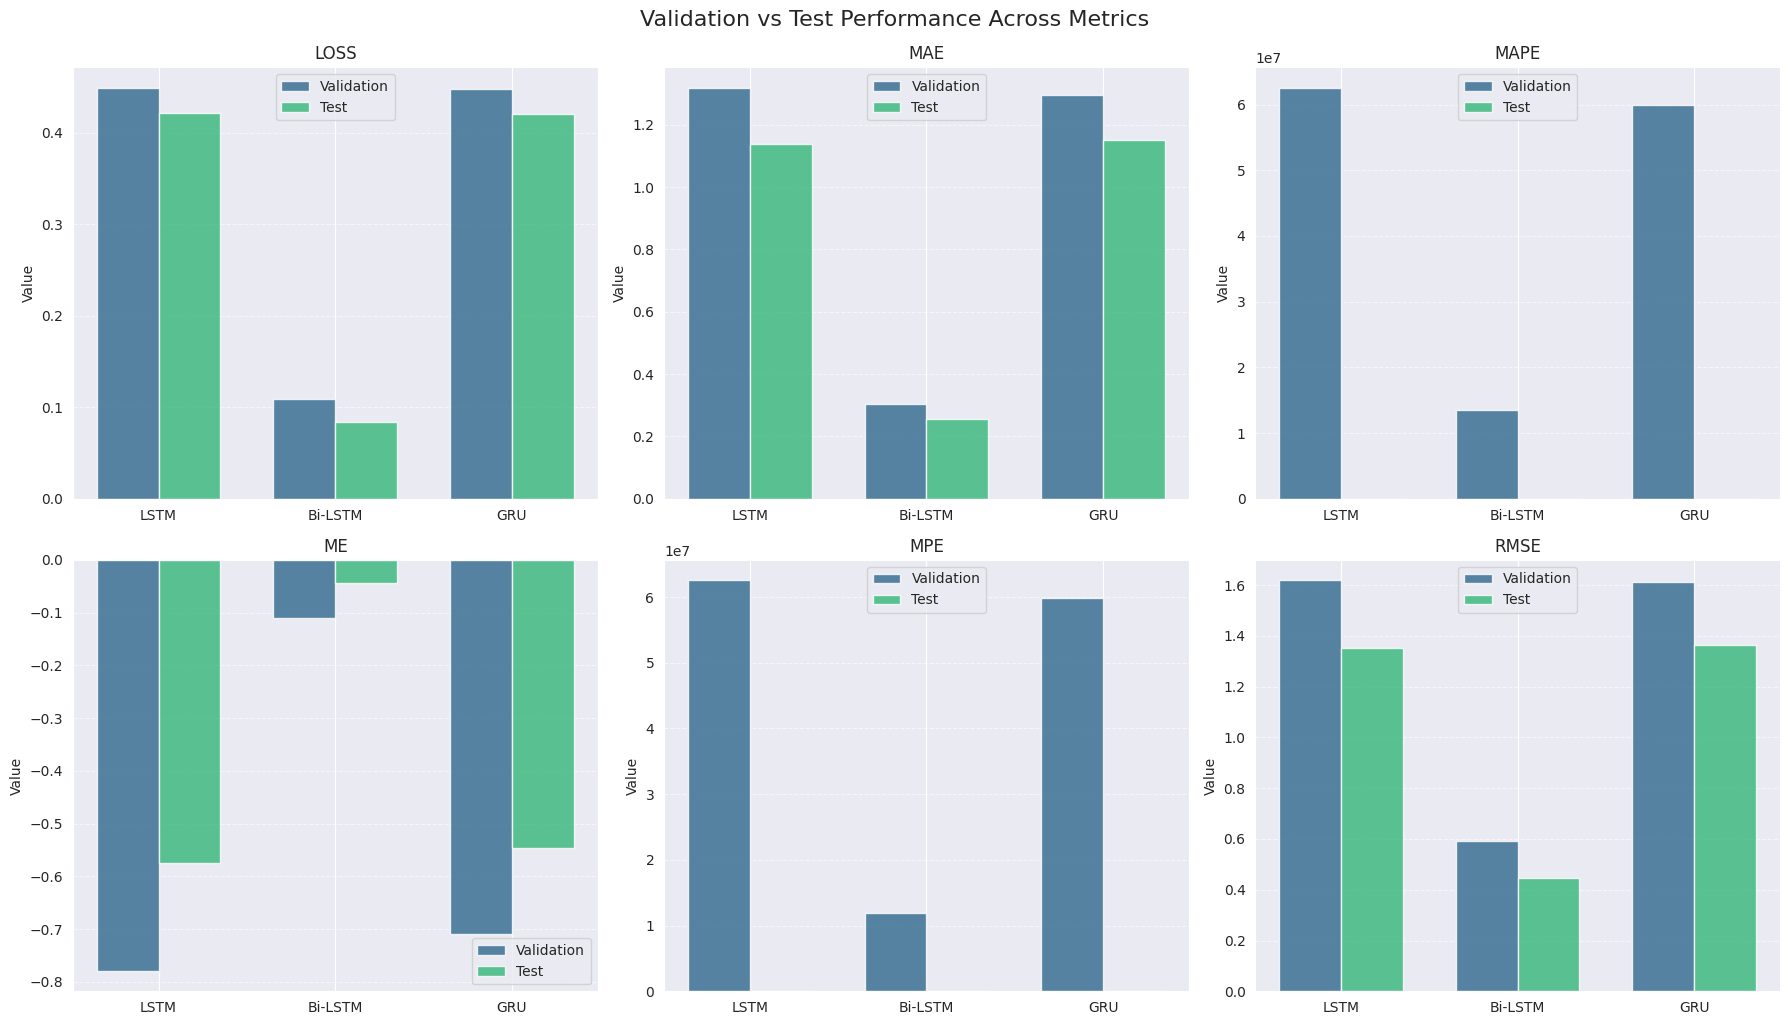

In [61]:
# Extract metrics and models
metrics = list(val_performance['LSTM'].keys())
models = list(val_performance.keys())

# Create a seaborn color palette
palette = sns.color_palette("viridis", 2)  

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()  

# Plot each metric in its own subplot
for i, metric_name in enumerate(metrics):
    ax = axes[i]
    
    # Get validation and test performance for the current metric
    val_ = [v[metric_name] for v in val_performance.values()]
    test_ = [v[metric_name] for v in performance.values()]
    
    x = np.arange(len(models))  # Position of bars
    width = 0.35  # Bar width
    
    # Bar plots for validation and test
    ax.bar(x - width/2, val_, width, label='Validation', color=palette[0], alpha=0.8)
    ax.bar(x + width/2, test_, width, label='Test', color=palette[1], alpha=0.8)
    
    # Title and labels
    ax.set_title(metric_name.upper())
    ax.set_ylabel("Value")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.suptitle("Validation vs Test Performance Across Metrics", y=1.02, fontsize=16)  
plt.show()
